In [3]:
from dask.distributed import Client
import dask
import matplotlib.pyplot as plt

import os
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["NUMEXPR_NUM_THREADS"] = "1" 
os.environ["OMP_NUM_THREADS"] = "1" 
import numpy as np

In [3]:
import os
os.chdir("/scratch/ak1774/runs")

In [ ]:
client = Client(n_workers=2, threads_per_worker=1)


In [ ]:
client

In [ ]:
def set_up_worker():
    import os
    os.environ["MKL_NUM_THREADS"] = "1" 
    os.environ["NUMEXPR_NUM_THREADS"] = "1" 
    os.environ["OMP_NUM_THREADS"] = "1" 
    
client.run(set_up_worker);

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from es_map import es_update
from es_map import distributed_evaluate
from es_map.interaction import interaction
from es_map import behavior_map
from es_map import novelty_archive

In [9]:
def get_random_individual(config):
    from es_map.interaction import interaction
    env = interaction.build_interaction_module(config["env_id"],config)
    theta = env.initial_theta()
    return theta

def calculate_obs_stats(sum,sumsq,count):
    if count == 0:
        return np.zeros_like(sum),np.ones_like(sum)
    mean = sum / count
    std = np.sqrt(np.maximum(sumsq / count - np.square(mean), 1e-2))
    return mean,std

def rank_based_selection(num_parent_candidates,num_children,agressiveness=1.0):
    # agressiveness decide how agressively we want to select higher ranking individuals over lower ranking ones.
    # 1 is normal rank based probability, 0 is uniform,
    # The higher it is the more agressive the selection is.
    
    p = np.array(list(range(num_parent_candidates))) + 1.0
    p = p ** agressiveness
    p = p / np.sum(p)
    
    selected_indicies = np.random.choice(num_parent_candidates,size=num_children, replace=True, p=p)
    return selected_indicies
    
def plot_4d_map(b_map,plt_inline_mode=False):
    data_4d = []
    for val in b_map.data.reshape(-1):
        if val is not None:
            data_4d.append(val["eval_fitness"])
        else:
            data_4d.append(None)
    data_4d = np.array(data_4d).reshape(*b_map.data.shape)
    
    dim = b_map.data.shape
    data_2d = np.zeros([dim[0]*dim[2],dim[1]*dim[3]])
    for coord1 in range(dim[0]):
        for coord2 in range(dim[1]):
            data_2d[coord1*dim[2]:(coord1+1)*dim[2],coord2*dim[3]:(coord2+1)*dim[3]] = data_4d[coord1,coord2]

    if plt_inline_mode is True:
        import matplotlib.pyplot as plt
        plt.imshow(data_2d)
        plt.colorbar()
    else:
        import matplotlib.pyplot as plt
        fig,ax = plt.subplots()
        ax.imshow(data_2d)
        #ax.colorbar()
    
        return fig,ax


In [10]:
config = {
    "env_id" : "DamageAnt-v2",
    "policy_args" : {
        "init" : "normc",
        "layers" :[256, 256],
       "activation" : 'tanh',
       "action_noise" : 0.01,
    },
    "env_args" : {
        "use_norm_obs" : True,
    },
    
    "ES_popsize" : 100,
    "ES_sigma" : 0.02,
    "ES_EVALUATION_BATCH_SIZE" : 5,
    "ES_lr" : 0.01,
    
    "ES_CENTRAL_NUM_EVALUATIONS" : 30,
    
    "GA_MAP_ELITES_NUM_GENERATIONS" : 1000,
    
    "GA_CHILDREN_PER_GENERATION" : 200,
    "GA_NUM_EVALUATIONS" : 10,
    
    "GA_MULTI_PARENT_MODE" : True,
    "GA_PARENT_SELECTION_MODE" : "rank_proportional",  # "uniform", "rank_proportional"
    "GA_RANK_PROPORTIONAL_SELECTION_AGRESSIVENESS" : 1.0,  # 0.0 uniform, 1.0 normal , higher more agressive
    "GA_MUTATION_POWER" : 0.02,
    
    "map_elites_grid_description" : {
        "bc_limits" : [[0,1],[0,1],[0,1],[0,1]],
        "grid_dims" : [6,6,6,6],
    },
    
    "CHECKPOINT_FREQUENCY" : 100,
    "PLOT_FREQUENCY" : 100,
}

In [11]:
import wandb
config
#wandb.config = config
wandb.init(project="evolvability_map_elites", entity="adam_katona")
wandb.run.name = "me_ga_multi_parent_ranked"
wandb.run.config.update(config)

run_name = wandb.run.dir.split("/")[-2]
run_checkpoint_path = "/scratch/ak1774/runs/large_files/" + run_name
os.makedirs(run_checkpoint_path,exist_ok=True)

wandb: Currently logged in as: adam_katona (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [12]:
def ga_select_parent_single_mode(non_empty_cells,config):
    # selects a single parent who is going to seed the next population
    # Used in the ES map elite paper as baseline, parralelizes to cluster well, 
    # but I think it is not ideal because the there are so few parent selected (1 per generation) 
    # returns single tuple 
    
    if len(non_empty_cells) == 0:
            parent_cell = None
            parent_params = get_random_individual(config)
            parent_obs_mean = None
            parent_obs_std = None
            
    else:
        if config["GA_PARENT_SELECTION_MODE"] == "uniform":
            parent_cell = np.random.choice(non_empty_cells)  # NOTE, here goes cell selection method
        elif config["GA_PARENT_SELECTION_MODE"] == "rank_proportional":
            sorted_cells = sorted(non_empty_cells,key=lambda x : x["eval_fitness"])                
            selected_index = rank_based_selection(num_parent_candidates=len(sorted_cells),
                                                     num_children=None, # only want a single parent
                                                     agressiveness=config["GA_RANK_PROPORTIONAL_SELECTION_AGRESSIVENESS"])
            parent_cell = sorted_cells[selected_index]

        else:
            raise "NOT IMPLEMENTED"

        parent_params = parent_cell["params"]
        parent_obs_mean,parent_obs_std = calculate_obs_stats( parent_cell["obs_stats"]["obs_sum"],
                                                              parent_cell["obs_stats"]["obs_sq"],
                                                              parent_cell["obs_stats"]["obs_count"])
        
    return parent_params,parent_obs_mean,parent_obs_std
    
    
def ga_select_parents_multi_parent_mode(non_empty_cells,config):
    # select a separate parent for every new child in the population
    # need to send separate parameter for each worker (not parraliliz very well), 
    # but I feel like this will be faster to explore and solve problems (we will see)
    parent_datas = []
        
    if len(non_empty_cells) == 0: # no parent available, create population from random individuals
        parent_list = [get_random_individual(config) for parent_i in range(config["GA_CHILDREN_PER_GENERATION"])]
        for parent_params in parent_list:
            parent_obs_mean = None
            parent_obs_std = None
            parent_datas.append((parent_params,parent_obs_mean,parent_obs_std))

    else:  # we have parents available
        if config["GA_PARENT_SELECTION_MODE"] == "uniform":
            parent_cell_list = np.random.choice(non_empty_cells,size=config["GA_CHILDREN_PER_GENERATION"])
        elif config["GA_PARENT_SELECTION_MODE"] == "rank_proportional":
            sorted_cells = sorted(non_empty_cells,key=lambda x : x["eval_fitness"])
            selected_indicies = rank_based_selection(num_parent_candidates=len(sorted_cells),
                                                     num_children=config["GA_CHILDREN_PER_GENERATION"],
                                                     agressiveness=config["GA_RANK_PROPORTIONAL_SELECTION_AGRESSIVENESS"])
            parent_cell_list = [sorted_cells[parent_i] for parent_i in selected_indicies]
        else:
            raise "NOT IMPLEMENTED"

        for parent_cell in parent_cell_list:
            parent_params = parent_cell["params"]
            parent_obs_mean,parent_obs_std = calculate_obs_stats( parent_cell["obs_stats"]["obs_sum"],
                                                                  parent_cell["obs_stats"]["obs_sq"],
                                                                  parent_cell["obs_stats"]["obs_count"])
            parent_datas.append((parent_params,parent_obs_mean,parent_obs_std))
    return parent_datas
    

In [ ]:

DEBUG = False
if DEBUG is True:
    config["GA_CHILDREN_PER_GENERATION"] = 20
    config["GA_NUM_EVALUATIONS"] = 4
    
b_map = behavior_map.Grid_behaviour_map(config)
b_archive = novelty_archive.NoveltyArchive(bc_dim = len(config["map_elites_grid_description"]["grid_dims"]))
    
run_name = wandb.run.dir.split("/")[-2]
run_checkpoint_path = "/scratch/ak1774/runs/large_files/" + run_name

evaluations_per_generation = config["GA_CHILDREN_PER_GENERATION"] * config["GA_NUM_EVALUATIONS"]
# es evaluations
# evaluations_per_generation = config["ES_popsize"] + config["ES_CENTRAL_NUM_EVALUATIONS"] 
    
generation_number = 0
evaluations_so_far = 0
best_fitness_so_far = 0
best_model_so_far = None
    

while True:
    if generation_number >= config["GA_MAP_ELITES_NUM_GENERATIONS"]:
        print("Done, reached iteration: ",config["GA_MAP_ELITES_NUM_GENERATIONS"])
        break
       
    ##########################################
    ## SELECT PARENTS AND EVALUATE_CHILDREN ##
    ##########################################
    non_empty_cells = b_map.get_non_empty_cells(config)
    
    # single perent mode, this was used in original es map elites implementation (also normal map elites)
    if config["GA_MULTI_PARENT_MODE"] is False:
        parent_params,parent_obs_mean,parent_obs_std = ga_select_parent_single_mode(non_empty_cells,config)
        child_results = distributed_evaluate.ga_evaluate_children_single_parent(client,theta=parent_params,
                                                                                obs_mean=parent_obs_mean,
                                                                                obs_std=parent_obs_std,
                                                                                config=config)
    else:
        parent_datas = ga_select_parents_multi_parent_mode(non_empty_cells,config)
        child_results = distributed_evaluate.ga_evaluate_children_multi_parent(client,parent_datas,config)
    
    #####################################################
    ## DECIDE IF CHILDREN NEEDS TO BE ADDED TO ARCHIVE ## 
    #####################################################
    for child_res in child_results:
        
        mean_fitness = child_res["mean_fitness"]
        mean_bc = child_res["mean_bc"]
        
        # try to add them to the archive
        if mean_fitness > best_fitness_so_far:
            best_fitness_so_far = mean_fitness
            best_model_so_far = child_res["child"]
            
        coords = b_map.get_cell_coords(mean_bc,config)
        cell = b_map.data[coords]        
                
        need_adding = False
        if cell is None:
            need_adding = True
        elif mean_fitness > cell["eval_fitness"]:
            need_adding = True
            
            
        if need_adding is True:
            updated_cell = {
                "params" : child_res["child"],
                "generation_created" : generation_number,

                "eval_fitness" : mean_fitness,
                "eval_bc" : mean_bc,

                "obs_stats" : {   # used for observation normalization. These stats are used for the children as well ??
                    "obs_sum" : child_res["child_obs_sum"],
                    "obs_sq" : child_res["child_obs_sq"],
                    "obs_count" : child_res["child_obs_count"],
                },
            }
        b_map.data[coords] = updated_cell
    
    ########################
    ## EVERY STEP LOGGING ##
    ########################
    
    print(generation_number,len(non_empty_cells),best_fitness_so_far)
    
    # Calculate things for logging
    generation_fitneses = [child_res["mean_fitness"] for child_res in child_results]
    generation_bc = np.stack([child_res["mean_bc"] for child_res in child_results])
    
    # Do the step logging 
    step_logs = {
        "generation_number" : generation_number,
        "nonempty_cells" : len(non_empty_cells),
        "nonempty_ratio" : float(len(non_empty_cells)) / b_map.data.size,
        "best_fitness_so_far" : best_fitness_so_far,
        "generation_fitness_mean" : np.mean(generation_fitneses),
        "generation_fitness_std" : np.std(generation_fitneses),
        "generation_bc_mean" : np.mean(generation_bc,axis=0),
        "generation_bc_std" : np.std(generation_bc,axis=0),
    }
    wandb.log(step_logs)
    
    ####################
    ## N STEP LOGGING ##
    ####################
    
    # Do the n-step logging
    if generation_number % config["PLOT_FREQUENCY"] == 10:
        # do plot map
        # save map without heavy stuff???
        #fig,ax = plot_4d_map(b_map)
        #n_step_log = {
        #    "b_map_plot" : fig,
        #}
        #wandb.log(n_step_log)
        
        # also print some stuff to console
        print(generation_number)
        for k,v in step_logs.items():
            print(k,v)
            
    ###################
    ## CHECKPOINTING ##
    ###################
            
    # Do checkpointing
    if generation_number % config["CHECKPOINT_FREQUENCY"] == 10:
        #np.save(run_checkpoint_path+"/best_model.npy",best_model_so_far)
        #np.save(run_checkpoint_path+"/b_map.npy",b_map.data,allow_pickle=True)
        #b_archive.save_to_file(run_checkpoint_path+"/b_archive.npy")
        pass
            
    generation_number += 1
    

################
## FINAL SAVE ##
################
print("Doing final save!")
np.save(run_checkpoint_path+"/best_model.npy",best_model_so_far)
np.save(run_checkpoint_path+"/b_map.npy",b_map.data,allow_pickle=True)
b_archive.save_to_file(run_checkpoint_path+"/b_archive.npy")
print("Final save done: ", run_checkpoint_path)
        
        
    
    

0 0 1006.5315212950112
1 55 1041.5059200386
2 86 1041.5059200386
3 112 1041.5059200386
4 134 1088.6191700371842
5 166 1143.1136234015187
6 189 1143.1136234015187
7 221 1143.1136234015187
8 255 1143.1136234015187
9 289 1143.1136234015187
10 320 1143.1136234015187
10
generation_number 10
nonempty_cells 320
nonempty_ratio 0.24691358024691357
best_fitness_so_far 1143.1136234015187
generation_fitness_mean 919.6378311980307
generation_fitness_std 155.68794517533894
generation_bc_mean [0.58448742 0.63840756 0.59919076 0.68989882]
generation_bc_std [0.38281172 0.36877517 0.37885357 0.34894781]
11 339 1158.2908581666713
12 360 1158.2908581666713
13 382 1165.7271471479983
14 394 1165.7271471479983
15 404 1165.7271471479983
16 419 1165.7271471479983
17 431 1245.1832144465975
18 440 1245.1832144465975
19 451 1245.1832144465975
20 458 1245.1832144465975
21 468 1245.1832144465975
22 481 1245.1832144465975
23 490 1245.1832144465975
24 498 1245.1832144465975
25 507 1245.1832144465975
26 515 1245.18321

In [16]:
run_path = "/scratch/ak1774/runs/large_files/run-20211230_145000-1n9zkioo"

In [23]:
a = np.load(run_path+"/b_map.npy",allow_pickle=True)
b_map = behavior_map.Grid_behaviour_map(config)
b_map.data = a

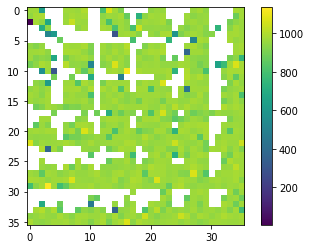

In [32]:
plot_4d_map(b_map,plt_inline_mode=True)


In [ ]:
clinet.shutdown()

In [15]:
probabilities = np.array(list(range(10)))+1
np.sum(probabilities / np.sum(probabilities))

1.0

In [ ]:
size=None, replace=True, p=None

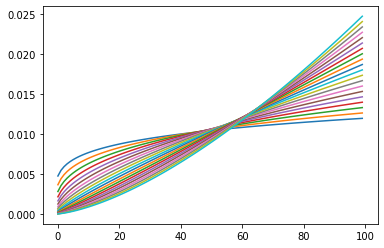

In [37]:
selection_agressiveness = 1.2

x = np.array(list(range(100)))
for agressiveness in np.linspace(0.2,1.5,20):
    p = (x+1)**agressiveness
    plt.plot(p / np.sum(p))
    
    
#plt.legend(np.linspace(0.4,2,20))
    


In [43]:
def rank_based_selection(num_parent_candidates,num_children,agressiveness=1.0):
    # agressiveness decide how agressively we want to select higher ranking individuals over lower ranking ones.
    # 1 is normal rank based probability, 0 is uniform,
    # The higher it is the more agressive the selection is.
    
    p = np.array(list(range(num_parent_candidates))) + 1.0
    p = p ** agressiveness
    p = p / np.sum(p)
    
    selected_indicies = np.random.choice(num_parent_candidates,size=num_children, replace=True, p=p)
    return selected_indicies
    

In [50]:
rank_based_selection(10,5)

array([9, 9, 0, 8, 3])

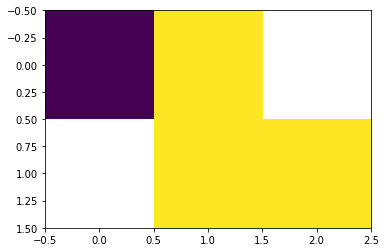

In [10]:
a = [[1,2,None],[None,2,2]]
a = np.array(a)
plt.imshow(a.astype(float))

In [12]:
import random

In [19]:
random.random()

0.7189881874550003

In [38]:

b = [1,2]
c = np.array([1,2])
a = [1,2,{1:2,"df":b,"r":c},b,np.array([1,2])]

In [39]:
b = np.array([1,2]) in a

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [37]:
b

False

In [33]:
a = np.zeros([3,2,2])

In [35]:
coords = tuple([0,0,0])
a[coords]

0.0

In [44]:
a = "/scratch/ak1774/runs/large_files/run-20220116_141838-2amerzjn"
b = np.load(a+"/b_map.npy",allow_pickle=True)

In [46]:
b[b != None]

array([{'elite': {'params': array([-0.06451311,  0.04718861, -0.07338245, ..., -0.06208653,
        0.04848045,  0.07383127], dtype=float32), 'ID': 13, 'parent_ID': 0, 'generation_created': 12, 'child_eval': {'noise_descriptors': [(37646946, 1), (57477906, 1), (77029593, 1), (86531425, 1), (49674243, 1), (26972782, 1), (37646946, -1), (57477906, -1), (77029593, -1), (86531425, -1), (49674243, -1), (26972782, -1)], 'fitnesses': array([ 9.82469143,  8.65960205, 10.13977822,  9.9727642 ,  9.61557709,
        9.80145043,  8.81569486,  9.77125109,  9.76602449,  9.82234775,
        9.77620202,  9.88119979]), 'bcs': array([[0.        , 0.        , 0.        , 0.        ],
       [0.05      , 0.        , 0.        , 0.        ],
       [0.0952381 , 0.0952381 , 0.04761905, 0.14285714],
       [0.        , 0.        , 0.05      , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.05      ],
       [0.        , 0.        , 0.       

In [52]:
import torch
import scipy.spatial.distance

In [131]:
bcs = torch.randn(20,2)
dists = scipy.spatial.distance.squareform(
            scipy.spatial.distance.pdist(bcs, "sqeuclidean")
        )
dists

tensor([[ 0.6480,  1.3244],
        [-1.1253,  0.2850],
        [-0.0781,  0.3708],
        [ 0.6268,  0.1596],
        [-1.7415,  0.2714],
        [-0.1542, -0.1237],
        [ 0.5967, -1.0454],
        [ 0.5588,  0.0204],
        [ 0.7688, -0.1304],
        [ 0.2297, -0.3764],
        [-0.7465, -1.5045],
        [ 0.6833, -0.7507],
        [ 1.0523, -2.2160],
        [-0.9960, -2.0683],
        [ 0.2474, -0.1220],
        [-0.8897, -0.1326],
        [-0.8942,  0.1573],
        [ 1.6595, -0.3385],
        [ 0.0801,  0.1902],
        [-0.5915,  0.9967]])

In [132]:
dists = scipy.spatial.distance.squareform(
            scipy.spatial.distance.pdist(bcs, "sqeuclidean")
        )
dists

array([[ 0.        ,  4.22519946,  1.43657683,  1.35722346,  6.81841541,
         2.74071899,  5.61867842,  1.70841   ,  2.1312759 ,  3.06768473,
         9.94770026,  4.30747092, 12.69804783, 14.21299826,  2.25257272,
         4.48764042,  3.74060462,  3.7883038 ,  1.60889981,  1.64380451],
       [ 4.22519946,  0.        ,  1.10409296,  3.08563064,  0.37978869,
         1.11019964,  4.73513276,  2.90646998,  3.7602971 ,  2.2735621 ,
         3.34587284,  4.3439522 , 10.9967385 ,  5.55447442,  2.0499486 ,
         0.22989307,  0.06972195,  8.14384487,  1.46204013,  0.79156661],
       [ 1.43657683,  1.10409296,  0.        ,  0.541451  ,  2.77667259,
         0.25039168,  2.46094558,  0.52847936,  0.96848738,  0.65304995,
         3.96375414,  1.83762064,  7.96931561,  6.79164105,  0.34877577,
         0.91222557,  0.71163762,  3.52222469,  0.05763258,  0.65538274],
       [ 1.35722346,  3.08563064,  0.541451  ,  0.        ,  5.62104355,
         0.69020123,  1.45296368,  0.0239948 ,  

In [133]:
# kernel density estimate
kde = np.zeros([50,50])
for x_i,x in enumerate(np.linspace(-2,2,50)):
    for y_i,y in enumerate(np.linspace(-2,2,50)):
        vec = torch.from_numpy(np.array([x,y]))
        diffs = bcs - vec
        distances = torch.sum(diffs * diffs,dim=1)
        p = torch.mean(torch.exp(-distances/0.2))
        kde[x_i,y_i] = p


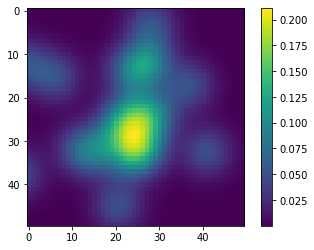

In [134]:
plt.imshow(kde)
plt.colorbar()

In [135]:
np.sum(kde) * ((40/500)**2)

0.5554664233466602

In [144]:
bcs = torch.randn(20,2)
dists = scipy.spatial.distance.squareform(
            scipy.spatial.distance.pdist(bcs, "sqeuclidean")
        )
dists2 = scipy.spatial.distance.squareform(
            scipy.spatial.distance.pdist(bcs*0.1, "sqeuclidean")
        )

In [145]:
dists_t = torch.from_numpy(dists)
k = torch.exp(-dists_t) 
p = torch.mean(k,dim=1)
entropy = -1*torch.sum(p*torch.log(p))
entropy

tensor(6.7648, dtype=torch.float64)

In [146]:
dists_t = torch.from_numpy(dists2)
k = torch.exp(-dists_t) 
p = torch.mean(k,dim=1)
entropy = -1*torch.sum(p*torch.log(p))
entropy

tensor(0.5234, dtype=torch.float64)

In [148]:
# J = E(bc-bc_mean)**2
# grad(E{})

In [ ]:
J = E{f}
J = var(BC) = E{(bc-bc_mean)**2} 
J = ent(p(bc)) = SUM(-p*log(p)) = -E{log(p)}
# but here p also depends on epsilon

grad E{f} = E_epsilon{ F(theta+sigma*epsilon) * epsilon} 
grad E{(bc-bc_mean)**2} = E_epsilon{ (bc(theta+sigma*epsilon)-bc_mean)**2 * epsilon} =
    1/N * SUM((bc(theta+sigma*epsilon)-bc_mean)**2 * epsilon) 
    
grad -E{log(p)} = -E_epsilon{ log(p(theta+sigma*epsilon)) * epsilon} 

p(epsilon) = SUM(kernel(epsilon))
E{log(p)} = SUM( log(p(epsilon)) * prob(epsilon))
E{log(p)} = SUM( log(SUM(kernel(epsilon))) * prob(epsilon))

# How should I change theta to maximize Entropy
# Do the weighted sum of the contribution to the entropy




In [6]:

def fun(x):
    return 5 * np.sin(0.2 * x) * np.sin(20 * x)

import scipy.spatial.distance

def kern(b):
    k_sigma = 1.0  # kernel standard deviation
    pairwise_sq_dists = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(b.reshape(-1, 1), "sqeuclidean"))
    # pylint: disable=invalid-unary-operand-type
    k = np.exp(-pairwise_sq_dists / k_sigma ** 2)
    return k

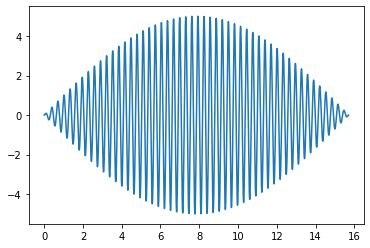

In [37]:
xs = np.linspace(0, 15.7, 5000)
ys = np.apply_along_axis(fun, 0, xs)
plt.plot(xs, ys)

In [59]:
npop = 3000  # population size
sigma = 0.5  # noise standard deviation
k_sigma = 1.0  # kernel standard deviation
alpha = 0.10  # learning rate

In [148]:
mus = []
variances = []
entropies = []
grads = []
grads2 = []
grads3 = []
term1 = []
term2 = []

# start the optimization
mu = 1.0
#for _ in range(2000):

for mu in np.linspace(1,5,50):

    print(mu)
    epsilons = sigma * np.random.randn(npop).reshape(-1,1)
    pop = mu + epsilons
    bcs = np.apply_along_axis(fun, 0, pop)

    var = bcs.var()
    entropy = -np.log(kern(bcs).mean(axis=1)).mean()

    mus.append(mu)
    variances.append(var)
    entropies.append(entropy)

    k = kern(bcs)
    p = k.mean(axis=1)
    log_p = np.log(p)
    #p_b = k.mean(axis=1)

    grad = np.matmul(-log_p,epsilons) / npop / sigma
    grads.append(grad)
    
    
    log_pi = epsilons / (sigma ** 2) 
    
    gard_term = -np.log(k.mean(axis=1)).dot(log_pi)
    other_term = -(k / k.mean(axis=0)).mean(axis=1).dot(log_pi)
    #print(grad,gard_term/npop,other_term/npop)
    
    grads2.append((gard_term+other_term)/npop)
    grad3 = -((k / k.mean(axis=0)).mean(axis=1) + np.log(k.mean(axis=1))).dot(log_pi)
    
    grads3.append(grad3)
    
    term1.append(gard_term/npop)
    term2.append(other_term/npop)


1.0
1.0816326530612246
1.163265306122449
1.2448979591836735
1.3265306122448979
1.4081632653061225
1.489795918367347
1.5714285714285714
1.6530612244897958
1.7346938775510203
1.816326530612245
1.8979591836734693
1.9795918367346939
2.061224489795918
2.142857142857143
2.224489795918367
2.3061224489795915
2.387755102040816
2.4693877551020407
2.5510204081632653
2.63265306122449
2.7142857142857144
2.7959183673469385
2.877551020408163
2.9591836734693877
3.0408163265306123
3.1224489795918364
3.204081632653061
3.2857142857142856
3.36734693877551
3.4489795918367343
3.530612244897959
3.6122448979591835
3.693877551020408
3.7755102040816326
3.8571428571428568
3.9387755102040813
4.020408163265306
4.1020408163265305
4.183673469387754
4.26530612244898
4.346938775510203
4.428571428571429
4.5102040816326525
4.591836734693877
4.673469387755102
4.755102040816326
4.836734693877551
4.918367346938775
5.0


In [16]:
(k / k.mean(axis=0)).mean(axis=1)

array([1.12820476, 1.13621519, 1.01786831, ..., 1.06116724, 1.1493132 ,
       1.14485912])

array([0.7381674 , 0.74667854, 0.64261799, ..., 0.67958895, 0.75725447,
       0.75396822])

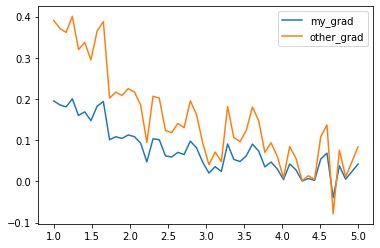

In [62]:
plt.plot(mus,grads)
#plt.plot(mus,grads2)
plt.plot(mus,term1)
#plt.plot(mus,term2)
plt.legend(["my_grad","other_grad","term1","term2"])

In [63]:
np.diff(entropies)

array([ 0.05185734,  0.04290653,  0.05260737,  0.04618577,  0.04795469,
        0.02597105,  0.04089052,  0.04695154,  0.0176487 ,  0.01955585,
        0.04741946,  0.03138649,  0.01548012,  0.03504842,  0.01408311,
        0.03788617,  0.02217895,  0.01538294,  0.01941765,  0.01886904,
        0.01981603,  0.02658202,  0.01098321,  0.02323358,  0.00784837,
        0.02751532,  0.01980624,  0.01229416,  0.01671096,  0.00701357,
        0.01628912,  0.01646201,  0.01598444,  0.01154409,  0.01159105,
        0.01218938,  0.01091035,  0.00732999,  0.01314599,  0.00273277,
        0.01150675,  0.01096496,  0.01948027,  0.00574681, -0.00268008,
        0.01852758,  0.00215846,  0.00447808,  0.0115643 ])

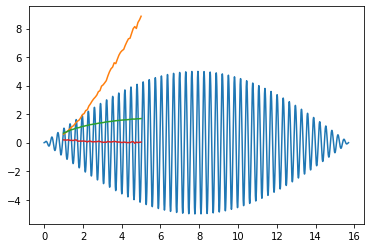

In [64]:
plt.plot(xs, ys)
plt.plot(mus,variances)
plt.plot(mus,entropies)
plt.plot(mus,grads)

In [149]:
numeric_grads = np.diff(entropies) / (4/50)

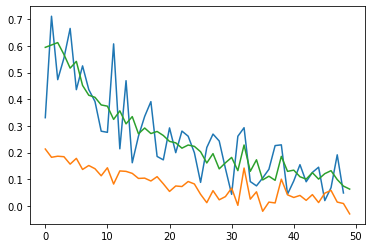

In [153]:
plt.plot(numeric_grads)
#plt.plot(entropies)
plt.plot(grads)
#plt.plot(grads2)
plt.plot(np.array(grads3)/npop)

In [72]:
(k / k.mean(axis=0)).shape

(3000, 3000)

In [73]:
k.mean(axis=0)

array([0.21813499, 0.19149683, 0.22930112, ..., 0.23917915, 0.15355541,
       0.13754383])

In [79]:
a = np.array([[1,2],[3,4]])
b = np.array([0.5,2])
a/b

array([[2., 1.],
       [6., 2.]])

In [82]:
(k / k.mean(axis=0)).mean(axis=1)

array([1.05776148, 0.99109692, 1.09121355, ..., 1.09985026, 0.94426856,
       0.97444209])

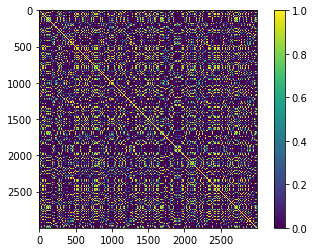

In [86]:
plt.imshow(k)
plt.colorbar()

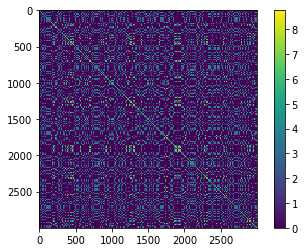

In [87]:
plt.imshow(k / k.mean(axis=0))
plt.colorbar()

In [ ]:
plt.imshow(k / k.mean(axis=0))

In [93]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=1.0).fit(bcs)
kde.score_samples(bcs)

array([-2.17304048, -2.23161659, -2.16036828, ..., -2.13193927,
       -2.3896238 , -2.52910776])

In [105]:
np.exp(kde.score_samples(bcs))

array([0.11383099, 0.10735474, 0.11528266, ..., 0.11860706, 0.09166416,
       0.07973013])

In [128]:
k_sigma = 1.0  # kernel standard deviation
pairwise_sq_dists = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(bcs.reshape(-1, 1), "sqeuclidean"))
# pylint: disable=invalid-unary-operand-type
k = np.exp(-pairwise_sq_dists / (2*k_sigma ** 2))

In [129]:
p = k.mean(axis=1)

In [144]:
q = (k / k.mean(axis=0)).mean(axis=1)
q2 = (k / k.mean(axis=1)).mean(axis=0)

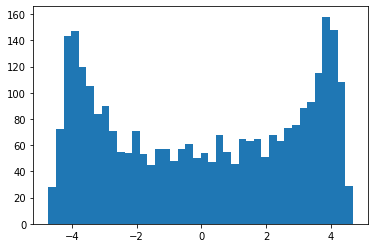

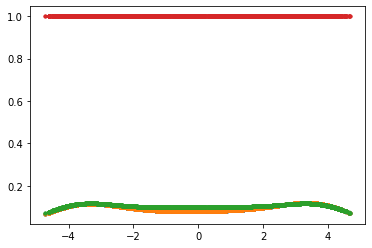

In [146]:
plt.hist(bcs,bins=40)
plt.show()
plt.plot(bcs.reshape(-1),np.exp(kde.score_samples(bcs)),".")
plt.plot(bcs.reshape(-1),p/2.5,".")
plt.plot(bcs.reshape(-1),q/9.5,".")


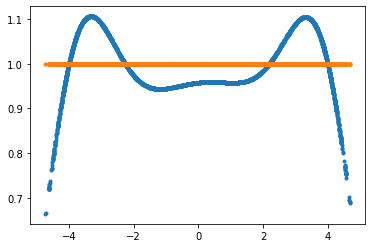

In [147]:
plt.plot(bcs.reshape(-1),q,".")
plt.plot(bcs.reshape(-1),q2,".")

In [ ]:
# entropy = sum_z(log(p(b(z))))
# p(b) = sum_z'(exp(b(z)-b(z')))
# entropy = sum_z(log(sum_z'(exp(b(z)-b(z'))))))

In [ ]:
# grad(entropy)